In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [15]:
df = pd.read_csv("datasets\merged_rides_weather\merged_rides_weather(100000).csv", parse_dates=["time_stamp"])


In [16]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,rain,humidity,wind
0,1.93,Lyft,2018-12-01 11:17:55.791,Back Bay,Haymarket Square,22.5,1.0,Lux Black,11,2018-12-01,32.580000,0.400000,1022.140000,0.019036,0.79,4.340000
1,1.05,Lyft,2018-11-29 06:53:05.635,North End,North Station,11.0,1.0,Lyft XL,6,2018-11-29,37.738571,0.774286,1000.315714,0.017956,0.70,10.212857
2,1.64,Uber,2018-12-16 22:30:08.069,Back Bay,Northeastern University,8.5,1.0,UberX,22,2018-12-16,41.860000,0.900000,1012.430000,0.101100,0.78,11.040000
3,2.53,Lyft,2018-12-02 06:08:03.130,Northeastern University,Beacon Hill,22.5,1.0,Lux Black,6,2018-12-02,38.380000,1.000000,1020.700000,0.017956,0.83,2.750000
4,1.71,Lyft,2018-12-16 00:40:15.848,South Station,West End,5.0,1.0,Shared,0,2018-12-16,42.690000,0.170000,1023.050000,0.129213,0.71,6.390000


In [17]:
# calculate price of Km
df['price_per_km'] = df['price'] / df['distance'].replace(0, np.nan)
df['price_per_km'] = df['price_per_km'].fillna(df['price_per_km'].median())

# to create datatime , hour, day of week
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['dayofweek'] = df['time_stamp'].dt.dayofweek # 0=Monday, 6=Sunday
df['date'] = df['time_stamp'].dt.date

# cyclic encoding for clock(sin,cos).
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
df['dow_sin'] = np.sin(2*np.pi*df['dayofweek']/7)
df['dow_cos'] = np.cos(2*np.pi*df['dayofweek']/7)



In [18]:
# 2) BASIC CLEANING
# =========================
df = df.dropna(subset=["distance", "price", "surge_multiplier"])
df["hour"] = df["time_stamp"].dt.hour
df["dayofweek"] = df["time_stamp"].dt.dayofweek

In [19]:
# 3) FEATURE SELECTION

num_features = [
    "distance", "price", "surge_multiplier", "price_per_km",
    "wind","rain","temp"
]

cat_features = [
    "cab_type", "name", "source", "destination"
]

num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]


In [21]:
# 4) PREPROCESSING PIPELINE

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features)
])

X = preprocessor.fit_transform(df)

In [22]:
# 5) PCA

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]
df["PC3"] = X_pca[:, 2]

In [23]:
# 6) KMEANS (k=10)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_pca)


In [24]:
# 7) DBSCAN (ANOMALY DETECTION)
dbscan_features = ["distance", "price", "price_per_km", "surge_multiplier"]
dbscan_features = [c for c in dbscan_features if c in df.columns]

scaler = StandardScaler()
X_db = scaler.fit_transform(df[dbscan_features])

dbscan = DBSCAN(eps=0.7, min_samples=10)
db_labels = dbscan.fit_predict(X_db)

df["anomaly"] = (db_labels == -1)

MemoryError: bad allocation

In [ ]:
# 8) CLUSTER VALIDATION
silhouette = silhouette_score(X_pca, df["cluster"])
print("Silhouette Score:", silhouette)

Silhouette Score: 0.2618198680151068


In [ ]:
# 9) MOBILITY CLUSTER PROFILES

# بنقسّم الداتا حسب رقم الـ Cluster
cluster_profiles = df.groupby("cluster").agg(
    rides_count=("distance", "count"), # عدد الرحلات في كل Cluster
    avg_distance=("distance", "mean"), # متوسط المسافة
    avg_price=("price", "mean"), # متوسط السعر
    avg_price_per_km=("price_per_km", "mean"), # متوسط السعر لكل كيلومتر
    peak_hour=("hour", lambda x: x.mode()[0] if not x.mode().empty else np.nan),#ساعة الذروة لكل Cluster
    common_source=("source", lambda x: x.mode()[0] if not x.mode().empty else np.nan),#أشهر نقطة انطلاق
    common_destination=("destination", lambda x: x.mode()[0] if not x.mode().empty else np.nan), #أشهر نقطة وصول
    anomaly_ratio=("anomaly", "mean") #نسبة الرحلات الشاذة
).reset_index()

print(cluster_profiles)

   cluster  rides_count  avg_distance  avg_price  avg_price_per_km  peak_hour  \
0        0         4603      4.850313  27.749261          5.871018          0   
1        1         6890      0.931299  23.892090         29.914680         13   
2        2        11563      2.883476  14.191213          5.103477         11   
3        3        20618      1.230898  11.081657          9.790671          0   
4        4        18019      2.809496  13.073644          4.791771          0   
5        5        13445      2.580167  26.645370         10.693361          0   
6        6           17      0.028235  20.617647        764.215686         18   
7        7         5184      2.790201  44.329186         18.081063         13   
8        8        12796      1.227040  12.285011         10.956173         10   
9        9         6865      2.683021  28.449599         11.315784         12   

             common_source  common_destination  anomaly_ratio  
0       Financial District  Financial Distri

In [ ]:
print(df["cluster"].value_counts())

cluster
3    20618
4    18019
5    13445
8    12796
2    11563
1     6890
9     6865
7     5184
0     4603
6       17
Name: count, dtype: int64


In [ ]:
print("Anomaly Counts:")
print(df["anomaly"].value_counts())

Anomaly Counts:
anomaly
False    99894
True       106
Name: count, dtype: int64


In [ ]:
# 10) SAVE RESULTS
df.to_csv("rides_with_clusters_and_anomalies.csv", index=False)
cluster_profiles.to_csv("cluster_profiles.csv", index=False)

In [ ]:
profiles = pd.read_csv("cluster_profiles.csv")
print(profiles)

   cluster  rides_count  avg_distance  avg_price  avg_price_per_km  peak_hour  \
0        0         4603      4.850313  27.749261          5.871018          0   
1        1         6890      0.931299  23.892090         29.914680         13   
2        2        11563      2.883476  14.191213          5.103477         11   
3        3        20618      1.230898  11.081657          9.790671          0   
4        4        18019      2.809496  13.073644          4.791771          0   
5        5        13445      2.580167  26.645370         10.693361          0   
6        6           17      0.028235  20.617647        764.215686         18   
7        7         5184      2.790201  44.329186         18.081063         13   
8        8        12796      1.227040  12.285011         10.956173         10   
9        9         6865      2.683021  28.449599         11.315784         12   

             common_source  common_destination  anomaly_ratio  
0       Financial District  Financial Distri

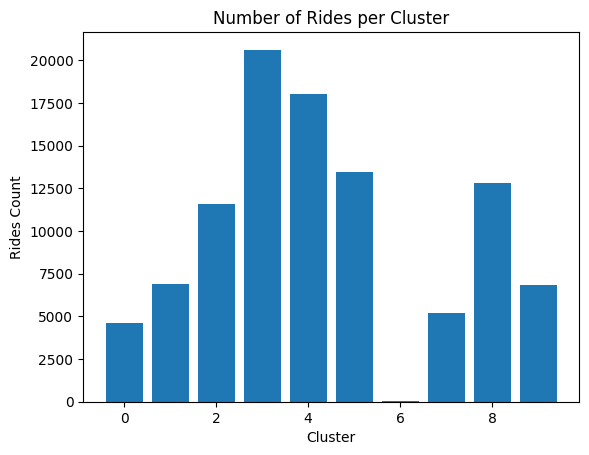

In [ ]:
plt.figure()
plt.bar(cluster_profiles["cluster"], cluster_profiles["rides_count"])
plt.title("Number of Rides per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Rides Count")
plt.show()


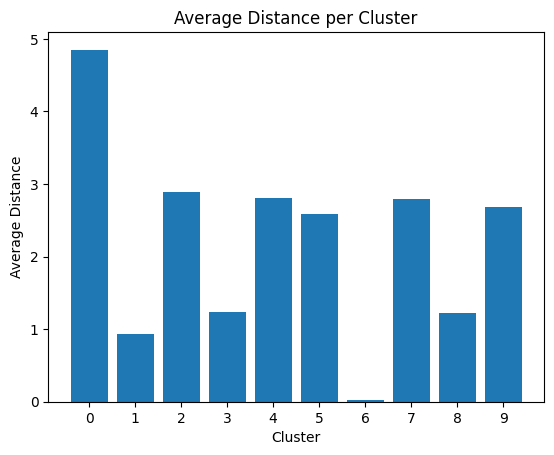

In [ ]:
plt.figure()

plt.bar(cluster_profiles["cluster"].astype(str),
        cluster_profiles["avg_distance"])

plt.title("Average Distance per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Distance")
plt.show()



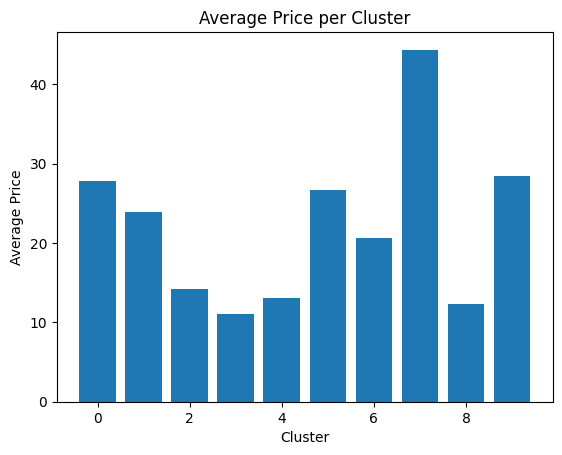

In [ ]:

plt.figure()
plt.bar(cluster_profiles["cluster"], cluster_profiles["avg_price"])
plt.title("Average Price per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Price")
plt.show()


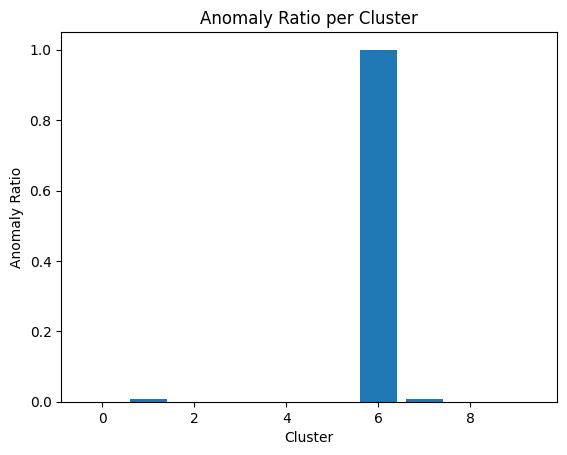

In [ ]:
plt.figure()
plt.bar(cluster_profiles["cluster"], cluster_profiles["anomaly_ratio"])
plt.title("Anomaly Ratio per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Anomaly Ratio")
plt.show()


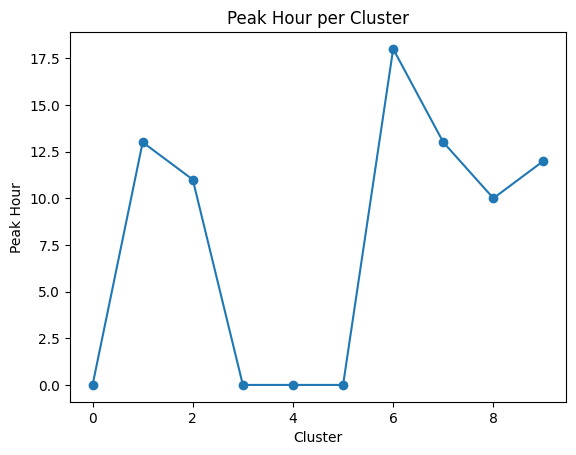

In [ ]:
plt.figure()
plt.plot(cluster_profiles["cluster"], cluster_profiles["peak_hour"], marker="o")
plt.title("Peak Hour per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Peak Hour")
plt.show()


<Figure size 640x480 with 0 Axes>

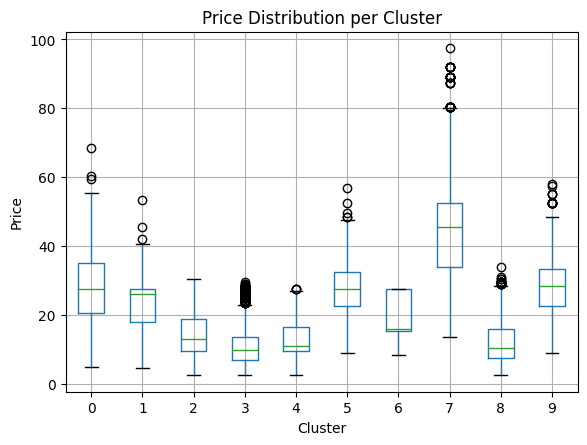

In [ ]:
plt.figure()
df.boxplot(column="price", by="cluster")
plt.title("Price Distribution per Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.show()


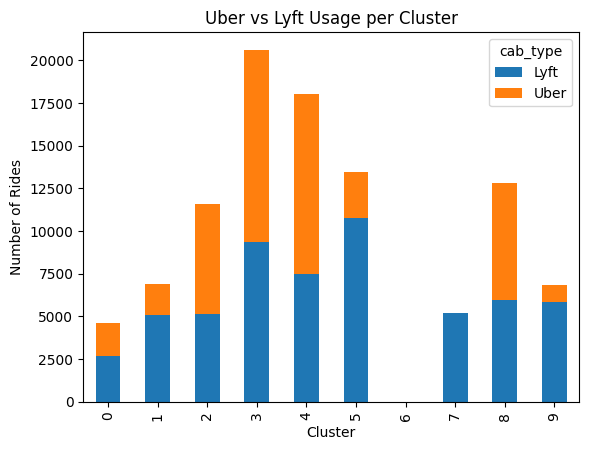

In [ ]:
service_counts = df.groupby(["cluster", "cab_type"]).size().unstack()

service_counts.plot(kind="bar", stacked=True)
plt.title("Uber vs Lyft Usage per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Rides")
plt.show()
